# **Import library**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from collections import deque
import random
import seaborn as sns
sns.set()

# **Read stock dataset**

In [2]:
# Using dataset from txt file
data = pd.read_csv('googl.us.txt')
data

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0
...,...,...,...,...,...,...,...
3328,2017-11-06,1049.100,1052.59,1042.000,1042.680,913954,0
3329,2017-11-07,1049.650,1053.41,1043.000,1052.390,1303832,0
3330,2017-11-08,1050.050,1062.69,1047.050,1058.290,1214469,0
3331,2017-11-09,1048.000,1050.88,1035.850,1047.720,1793994,0


In [51]:
fig = px.line(data, x='Date', y="Close")
fig.show()

To benchmark with the paper, we will use the data stock price of Google from 01-Jan-2015 to 10-November-2017. Since 01-Jan-2015 was public holiday and no trading on that day, therefore, price at 02-Jan-2015 is used as starting point for training. The **training set** is from date 02-January-2015 until 31-December-2016 and total **504 sample points**. Period of time from 01-January-2017 until 10-November-2017 as **testing set** which has **218 samples**.

In [3]:
def get_index(date):
  for no, i in enumerate(data.Date):
    if i == date:
      index = no
  return index

In [4]:
# get index from training and testing period
train_start_index = get_index('2015-01-02')
train_end_index = get_index('2016-12-30')
test_start_index = get_index('2017-01-03')
test_end_index = get_index('2017-11-10')

train_set = data[train_start_index:train_end_index + 1]
test_set = data[test_start_index:test_end_index + 1]
print('Total data length :',len(data))
print('Train data length :',len(train_set))
print('Test data length :',len(test_set))

Total data length : 3333
Train data length : 504
Test data length : 218


In [5]:
train_set

,Date,Open,High,Low,Close,Volume,OpenInt
2611,2015-01-02,532.60,535.800,527.880,529.55,1327665,0
2612,2015-01-05,527.15,527.990,517.750,519.46,2057089,0
2613,2015-01-06,520.50,521.210,505.550,506.64,2731728,0
2614,2015-01-07,510.95,511.490,503.650,505.15,2345823,0
2615,2015-01-08,501.16,507.500,495.020,506.91,3662169,0
...,...,...,...,...,...,...,...
3110,2016-12-23,808.01,810.970,805.110,807.80,750685,0
3111,2016-12-27,808.68,816.000,805.800,809.93,946336,0
3112,2016-12-28,813.33,813.330,802.440,804.57,1159794,0
3113,2016-12-29,802.33,805.750,798.144,802.83,998255,0


# **DQN Agent**

In [6]:
class MemoryReplay():
    def __init__(self, mem_size, input_dims):
        self.mem_size = mem_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, input_dims), 
                                    dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int32)

    def store_transition(self, state, action, reward, next_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = next_state
        self.terminal_memory[index] = 1 - int(done)
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        states = self.state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        next_state = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, next_state, terminal

In [7]:
def build_dqn(lr, n_actions, input_dims):
  model = keras.Sequential()

  model.add(layers.Dense(128, input_shape = (input_dims,), activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(units = 256, activation='relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(n_actions))
  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss='categorical_crossentropy', optimizer=opt)

  return model

build_dqn(0.001, 3, 100).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 46,723
Trainable params: 46,723
Non-trainable params: 0
_________________________________________________________________


In [11]:
class DQNAgent:
    def __init__(self, data, window_size, skip, n_actions,
                 batch_size, mem_size, input_dims, 
                 gamma, epsilon, epsilon_min, ep_dec, lr):
      self.data = data
      self.window_size = window_size
      self.half_window = window_size // 2
      self.skip = skip
      self.n_actions = n_actions
      self.batch_size = batch_size
      self.memory = MemoryReplay(mem_size, input_dims)
      self.input_dims = input_dims
      self.gamma = 0.95
      self.epsilon = 0.5
      self.epsilon_min = 0.1
      self.epsilon_decay = 0.999
      self.q_eval = build_dqn(lr, n_actions, input_dims)
      self.q_target = build_dqn(lr, n_actions, input_dims)
      self.copy_network()
      self.inventory = []


    def act(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            actions = self.q_eval.predict(state)[0]
            action = np.argmax(actions)
        return action

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)
    
    def observe_price_diff(self, timestep):
        total_window_size = self.window_size + 1
        d = timestep - total_window_size + 1
        block = self.data[d : timestep + 1] if d >= 0 else -d * [self.data[0]] + self.data[0 : timestep + 1]
        diff = []
        for i in range(total_window_size - 1):
            diff.append(block[i + 1] - block[i])
        return np.array([diff])

    def test_trade(self, capital):
        starting_money = capital
        states_sell = []
        states_buy = []
        inventory = []
        profit = []
        balance = []

        state = self.observe_price_diff(0)

        for t in range(0, len(self.data) - 1, self.skip):
            action = self.act(state)
            next_state = self.observe_price_diff(t + 1)
            
            if action == 1 and capital >= self.data[t] and t < (len(self.data) - self.half_window):
                inventory.append(self.data[t])
                capital -= self.data[t]
                states_buy.append(t)
                balance.append(capital)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.data[t], capital))               
                
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                capital += self.data[t]
                states_sell.append(t)
                try:
                    invest = ((test_close[t] - bought_price) / bought_price) * 100
                    profit.append(invest)
                except:
                    invest = 0
                    profit.append(invest)
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, test_close[t], invest, capital)
                )
            
            state = next_state
        invest = ((capital - starting_money) / starting_money) * 100
        total_gains = capital - starting_money

        return states_buy, states_sell, total_gains, invest, profit, balance

    def copy_network(self):
        weights = self.q_eval.get_weights()
        self.q_target.set_weights(weights)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, next_state, dones = \
                self.memory.sample_buffer(self.batch_size)
        q_eval = self.q_eval.predict(states)
        q_next = self.q_target.predict(next_state)
        
        targets = q_eval        
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        targets[batch_index, actions] = rewards + self.gamma * np.max(q_next, axis=1)*dones

        self.q_eval.fit(states, targets, epochs=1, verbose=0)

        self.epsilon = self.epsilon * self.epsilon_decay if self.epsilon > self.epsilon_min else self.epsilon_min

    def train(self, epochs, checkpoint, capital):
      for i in range(epochs):
          profit = 0
          inventory = []
          state = self.observe_price_diff(0)
          starting_money = capital
          for t in range(0, len(self.data) - 1, self.skip):
              action = self.act(state)
              next_state = self.observe_price_diff(t + 1)
              
              # buy
              if action == 1 and starting_money >= self.data[t] and t < (len(self.data) - self.half_window):
                  inventory.append(self.data[t])
                  starting_money -= self.data[t]
              
              # sell
              elif action == 2 and len(inventory) > 0:
                  bought_price = inventory.pop(0)
                  profit += self.data[t] - bought_price
                  starting_money += self.data[t]
                  
              invest = (starting_money - capital) / capital
              agent.store_transition(state, action, invest, next_state, invest < -0.5)
              state = next_state
              agent.learn()
          self.copy_network()

          if (i+1) % checkpoint == 0:
              print('epoch: %d, epsilon: %.2f, ROI: %.3f, total money: %f'%(i + 1, self.epsilon, profit, starting_money))            

In [32]:
checkpoint = 1
capital = 10000
state_size = 100
n_actions = 3
skip = 1
batch_size = 128
close_prices = train_set.Close.values.tolist()

agent = DQNAgent(close_prices, state_size, skip, n_actions,
              batch_size, mem_size=1000, input_dims=state_size,
              gamma=0.99, epsilon=1.0, epsilon_min=0.05, ep_dec=0.995, lr=1e-5)

In [33]:
agent.train(epochs = 100, checkpoint = checkpoint, capital = capital)

epoch: 1, epsilon: 0.34, ROI: 274.920, total money: 10274.920000
epoch: 2, epsilon: 0.21, ROI: 177.390, total money: 10177.390000
epoch: 3, epsilon: 0.13, ROI: 46.440, total money: 10046.440000
epoch: 4, epsilon: 0.10, ROI: 80.710, total money: 10080.710000
epoch: 5, epsilon: 0.10, ROI: 34.020, total money: 10034.020000
epoch: 6, epsilon: 0.10, ROI: -67.010, total money: 9932.990000
epoch: 7, epsilon: 0.10, ROI: 7.330, total money: 10007.330000
epoch: 8, epsilon: 0.10, ROI: 132.190, total money: 10132.190000
epoch: 9, epsilon: 0.10, ROI: 40.500, total money: 10040.500000
epoch: 10, epsilon: 0.10, ROI: -38.950, total money: 9961.050000
epoch: 11, epsilon: 0.10, ROI: 149.100, total money: 10149.100000
epoch: 12, epsilon: 0.10, ROI: 33.680, total money: 10033.680000
epoch: 13, epsilon: 0.10, ROI: 155.930, total money: 10155.930000
epoch: 14, epsilon: 0.10, ROI: 400.380, total money: 10400.380000
epoch: 15, epsilon: 0.10, ROI: 1168.480, total money: 11168.480000
epoch: 16, epsilon: 0.10, R

# **Let's Trade**

In [34]:
test_close = test_set.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
test_agent = DQNAgent(data=test_close,
                      window_size=window_size,
                      skip=skip,
                      n_actions = n_actions,
                      batch_size = batch_size,
                      mem_size=1000, 
                      input_dims=30,
                      gamma=0.99, 
                      epsilon=1.0, 
                      epsilon_min=0.01, 
                      ep_dec=0.995, 
                      lr=0.01
                      )
states_buy, states_sell, total_gains, invest, profit, balance = test_agent.test_trade(capital = initial_money)

day 3: buy 1 unit at price 825.210000, total balance 9174.790000
day 5, sell 1 unit at price 826.010000, investment 0.096945 %, total balance 10000.800000,
day 12: buy 1 unit at price 828.170000, total balance 9172.630000
day 17, sell 1 unit at price 845.030000, investment 2.035814 %, total balance 10017.660000,
day 21: buy 1 unit at price 818.260000, total balance 9199.400000
day 22, sell 1 unit at price 820.130000, investment 0.228534 %, total balance 10019.530000,
day 27: buy 1 unit at price 834.850000, total balance 9184.680000
day 28, sell 1 unit at price 838.960000, investment 0.492304 %, total balance 10023.640000,
day 29: buy 1 unit at price 840.090000, total balance 9183.550000
day 30, sell 1 unit at price 837.320000, investment -0.329727 %, total balance 10020.870000,
day 34: buy 1 unit at price 851.360000, total balance 9169.510000
day 35, sell 1 unit at price 851.000000, investment -0.042285 %, total balance 10020.510000,
day 36: buy 1 unit at price 847.810000, total balanc

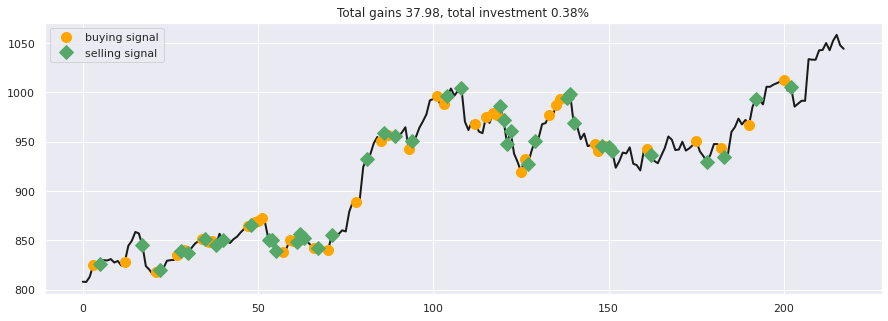

In [52]:
fig = plt.figure(figsize = (15,5))
plt.plot(test_close, color='k', lw=2.)
plt.plot(test_close, 'o', markersize=10, color='orange', label = 'buying signal', markevery = states_buy)
plt.plot(test_close, 'D', markersize=10, color='g', label = 'selling signal', markevery = states_sell)
plt.title('Total gains %.2f, total investment %.2f%%'%(total_gains, invest))
plt.legend()
plt.show()

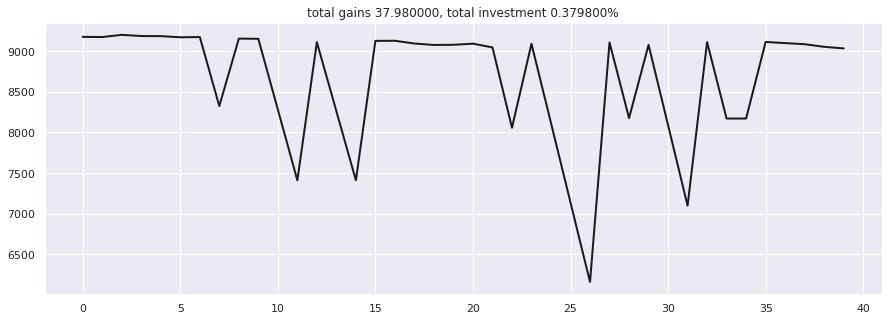

In [37]:
fig = plt.figure(figsize = (15,5))
plt.plot(balance, color='k', lw=2.)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.show()